<a href="https://colab.research.google.com/github/ioannis-toumpoglou/pytorch-repo/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets

## Domain Libraries

Depending on the problem, whether it is vision, text, audio or recommendation, look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0 and above is required
torch.__version__

'2.0.1+cu118'

In [2]:
# Setup device-agnostic device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get data

The dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

This dataset starts with 3 classes and only 10% of the images (~75 training, 25 testing).


Why?


When starting a ML project, it is important to try things out on a small scale and then gradually increase the scale, when necessary.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup a path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f'{image_path} directory already exists... Skipping download')
else:
  print(f'{image_path} directory doesn\'t exist... Creating directory')
  image_path.mkdir(parents=True,
                   exist_ok=True)

# Download data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as file:
  request = requests.get(url='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print(f'Downloading the dataset...')
  file.write(request.content)

# Unzip the downloaded file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping the dataset file...')
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory doesn't exist... Creating directory
Unzipping the dataset file...


## 2. Becoming one with the data (data preparation and exploration)

In [4]:
import os

def walk_through_dir(dir_path):
  """
    Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.


In [6]:
# Setup training and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Write code to:
1. Get all image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name
4. Open the image with Python PIL
5. Show image and print metadata

Random image path: data/pizza_steak_sushi/test/steak/100274.jpg
Image class: steak
Image height: 384
Image width: 512


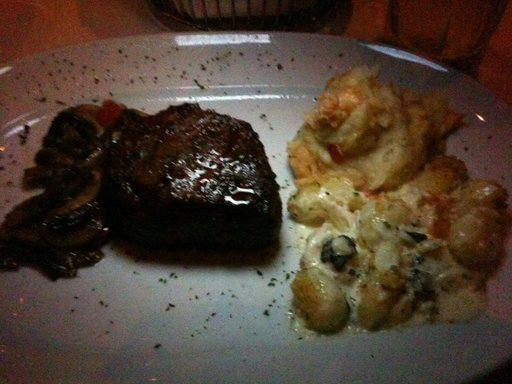

In [7]:
import random
from PIL import Image

# Set seed
torch.manual_seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Show image and print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

img

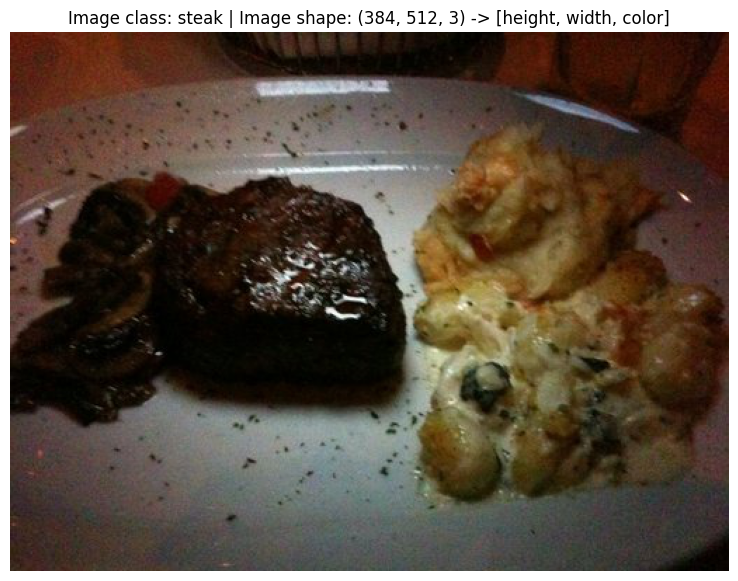

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color]')
plt.axis(False);

In [9]:
img_as_array

array([[[94, 31, 16],
        [96, 33, 18],
        [97, 34, 19],
        ...,
        [49,  9,  0],
        [54, 14,  2],
        [59, 17,  5]],

       [[94, 31, 16],
        [95, 32, 17],
        [92, 29, 14],
        ...,
        [53, 13,  3],
        [61, 19,  7],
        [64, 22,  8]],

       [[94, 28, 14],
        [94, 31, 16],
        [93, 30, 15],
        ...,
        [57, 17,  5],
        [64, 22, 10],
        [66, 24, 10]],

       ...,

       [[53, 39, 26],
        [57, 43, 30],
        [64, 48, 35],
        ...,
        [ 8,  3,  0],
        [ 8,  3,  0],
        [ 9,  4,  1]],

       [[57, 43, 30],
        [66, 52, 39],
        [65, 51, 38],
        ...,
        [ 6,  1,  0],
        [ 7,  2,  0],
        [ 7,  2,  0]],

       [[56, 42, 29],
        [64, 50, 37],
        [57, 43, 30],
        ...,
        [ 9,  4,  1],
        [ 9,  4,  1],
        [10,  5,  2]]], dtype=uint8)

## 3. Transforming data

Before using an image with PyTorch:
1. Turn the target data into tensors
2. Turn the target data into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms helps getting the images ready to be used with a model/platform data augmentation

In [11]:
# Write a transform form image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=[64, 64]),
    # Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.3647, 0.3608, 0.3686,  ..., 0.1216, 0.1216, 0.1922],
         [0.3569, 0.3569, 0.3490,  ..., 0.1294, 0.1333, 0.2275],
         [0.3490, 0.3569, 0.3216,  ..., 0.1294, 0.1529, 0.2627],
         ...,
         [0.2196, 0.2314, 0.2431,  ..., 0.1176, 0.0784, 0.0431],
         [0.2196, 0.2431, 0.2510,  ..., 0.0510, 0.0392, 0.0353],
         [0.2314, 0.2549, 0.2627,  ..., 0.0275, 0.0275, 0.0353]],

        [[0.1137, 0.1137, 0.1137,  ..., 0.0431, 0.0392, 0.0549],
         [0.1098, 0.1137, 0.1176,  ..., 0.0431, 0.0431, 0.0667],
         [0.1216, 0.1176, 0.1294,  ..., 0.0392, 0.0510, 0.0745],
         ...,
         [0.1490, 0.1529, 0.1569,  ..., 0.1098, 0.0471, 0.0196],
         [0.1412, 0.1490, 0.1529,  ..., 0.0353, 0.0157, 0.0196],
         [0.1569, 0.1529, 0.1529,  ..., 0.0196, 0.0196, 0.0196]],

        [[0.0510, 0.0471, 0.0471,  ..., 0.0196, 0.0275, 0.0235],
         [0.0510, 0.0549, 0.0549,  ..., 0.0196, 0.0235, 0.0314],
         [0.0627, 0.0667, 0.0667,  ..., 0.0196, 0.0235, 0.

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [14]:
data_transform(img).dtype

torch.float32

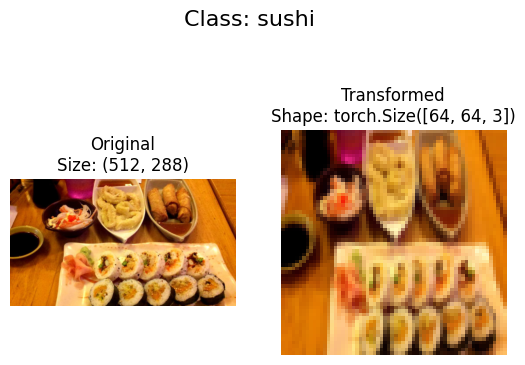

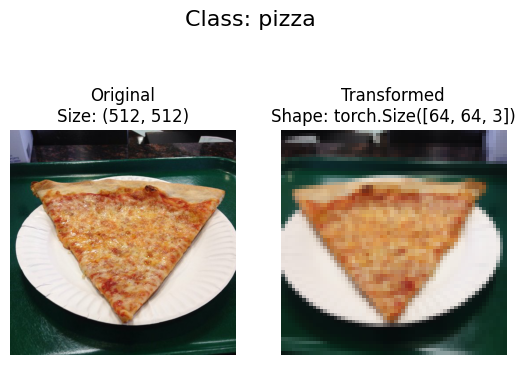

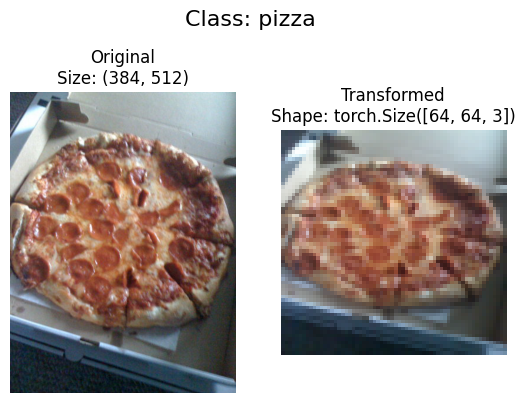

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
    Selects random images, loads/transforms them and plots the original vs transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, axis = plt.subplots(nrows=1, ncols=2)
      axis[0].imshow(f)
      axis[0].set_title(f'Original\nSize: {f.size}')
      axis[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)  # need to change shape for matplotlib (C, H , W) -> (H, W, C)
      axis[1].imshow(transformed_image)
      axis[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      axis[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

Image classification data can be loaded using `torchvision.datasets.ImageFolder`

In [16]:
# Use ImageFolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,   # a transform for the data
                                  target_transform=None)    # a teansform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# Get class names as a list
class_names = train_data.class_to_idx
class_names

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
len(train_data), len(test_data)

(225, 75)

In [19]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [20]:
# Index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor: {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color]


Text(0.5, 1.0, 'pizza')

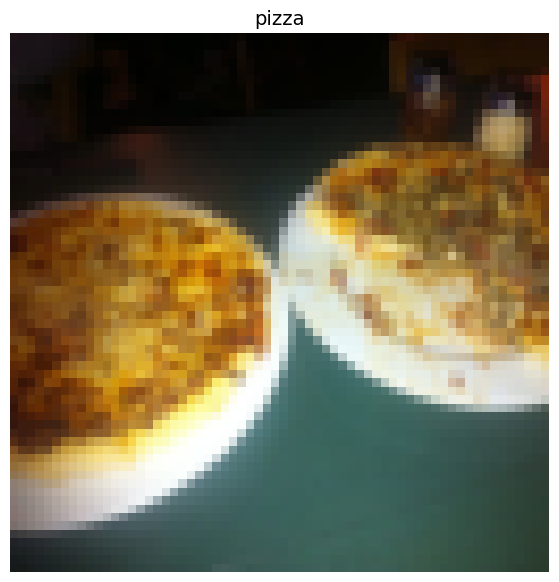

In [21]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Original shape: {img.shape} -> [color, height, width]')
print(f'Image permute: {img_permute.shape} -> [height, width, color]')

# Plot image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
res = dict((v,k) for k,v in class_names.items())
plt.title(res[label], fontsize=14)

### 4.1 Turn loaded images into data loaders

A `DataLoader` is going to help turn a `Dataset` into an iterable

In [22]:
import os
os.cpu_count()

2

In [23]:
# Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f9ae20129b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9ae2012ad0>)

In [24]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [25]:
len(train_data), len(test_data)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape} -> [batch_size, color, height, width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading image data with a custom dataset

1. Load images from file
2. Get class names from the dataset
3. Get classes as dictionary from the

Pros:
* Create a dataset out of almost anything
* Not limited to PyTorch pre-built dataset functions

Cons:
* Creating a dataset out of almost anything doesn't mean it will work
* Using a custom dataset often results in writing more code, prone to errors or performance issues

In [27]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

The function will:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally this directory is in standard image classification format)
2. Raise an error if the class names not found
3. Turn the class names into a dict and a list and return them

In [29]:
# Setup the path directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
    Finds the class folder names in a target directory.
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise error if class names not found
  if not classes:
    raise FileNotFoundError(f'Unable to find any classes in {directory}.. Please check file structure.')

  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate ImageFolder

To create a custom dataset:

1. Subclass `torch.utils.data.Dataset`
2. Init the subclass with a target directory as well as a transform, if the data need to transform
3. Create several attributes
  * paths - paths of images
  * transform - the transform to be used
  * classes - a list of target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load the images
5. Override the `__len()__` method to return the length of the dataset
6. Override the `__getitem()__` method to return a given sample when an index is passed

In [32]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Init custom dataset
  def __init__(self, targ_dir: str, transform=None):
    # 3. Create class attributes
    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Override __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.paths)

  # 6. Override __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns a sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [33]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [34]:
# Test ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [35]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f9a0f3bed70>,
 <__main__.ImageFolderCustom at 0x7f9a0f3bfee0>)

In [36]:
len(train_data), len(train_data_custom)

(225, 225)

In [37]:
len(test_data), len(test_data_custom)

(75, 75)

In [38]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [39]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [40]:
# Check for equality between original ImageFolder and ImageFolderCustom datasets
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters, such as class names and the number of images
2. To prevent the display from getting out of hand, limit the number of images to 10
3. Set the random seed
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through the random indexes and plot them
7. Make sure the images' dimensions line up with matplotlib (HWC)

In [41]:
# 1. Create a function to take a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Limit the number of images
  if n > 10:
    n = 10
    display_shape = False
    print(f'For display purposes, n shouldn not be larger than 10. \nSetting to 10 and removing shape display.')

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through the random indexes and plot the
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)   # [c, h, w] -> [h, w, c]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')

    if classes:
      res = dict((v,k) for k,v in class_names.items())
      title = f'Class: {res[targ_label]}'
      if display_shape:
        title = title + f'\nshape: {targ_image_adjust.shape}'
    plt.title(title)

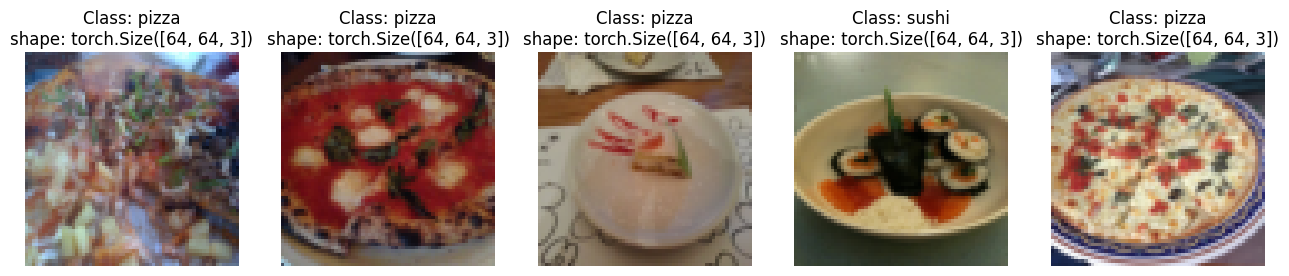

In [42]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

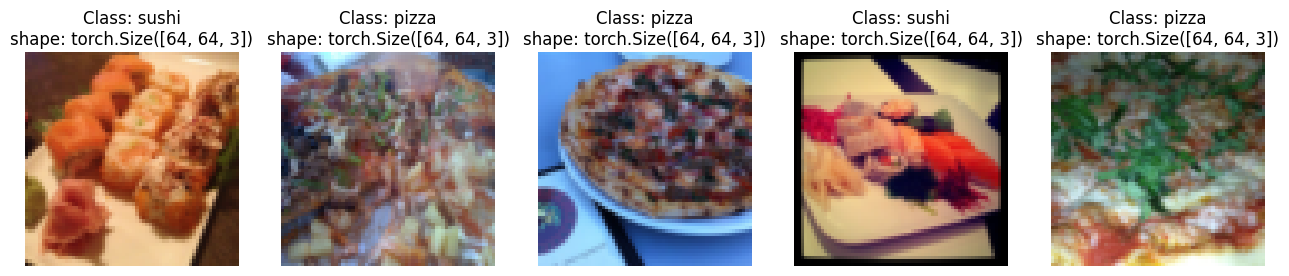

In [43]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images to `DataLoader`s

In [44]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f9a0e730130>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9a0e7300d0>)

In [45]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that is more generalizable to unseen data.

Following, a particular type of data augmentation used to train PyTorch vision models to state of the art levels is analyzed.

In [46]:
# Trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [47]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg')]

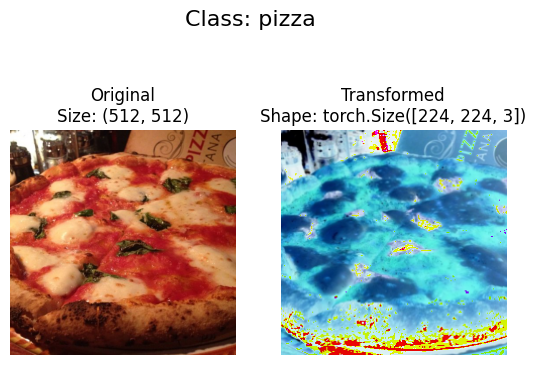

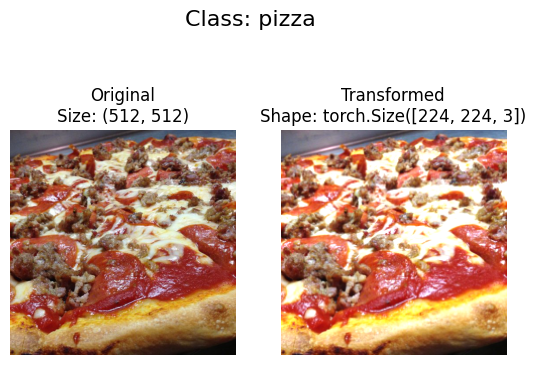

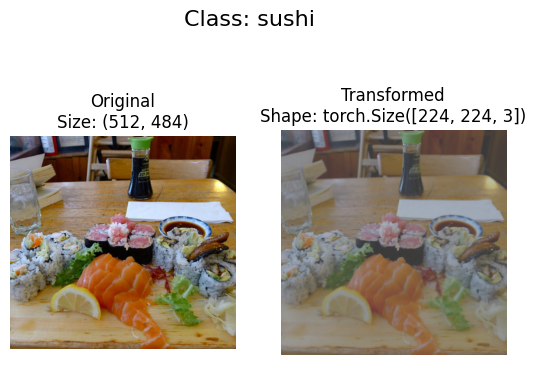

In [48]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data form Model 0

In [49]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [50]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [51]:
class TinyVGG(nn.Module):
  """
    Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)    # default stride value is same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)    # default stride value is same as kernel size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 13 * 13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))   # benefits from operator fusion

In [52]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Forward pass on a single image to test the model

In [53]:
# Get an image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [54]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2870e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7294e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8249e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through the model

In [55]:
# Install torchinfo, import it when available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [56]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()
  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)   # outputs model logits
    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    # Calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [57]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()
  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0
  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)
      # 1. Forward pass
      test_pred_logits = model(X)
      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [58]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  # 2. Create an empty results dictionary
  results = {
      'train_loss': [],
      'train_acc': [],
      'test_loss': [],
      'test_acc': []
  }
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # 4. Print out process
    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}')
    # 5. Update results dictionary
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  # 6. Return the filled results at the end of epochs
  return results

### 7.7 Train and evaluate model 0

In [59]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start timer
from timeit import default_timer as timer

start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer
end_time = timer()

print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train accuracy: 0.3047 | Test loss: 1.0979 | Test accuracy: 0.3305
Epoch: 1 | Train loss: 1.0835 | Train accuracy: 0.4453 | Test loss: 1.0775 | Test accuracy: 0.4223
Epoch: 2 | Train loss: 1.1042 | Train accuracy: 0.2812 | Test loss: 1.0827 | Test accuracy: 0.3930
Epoch: 3 | Train loss: 1.0753 | Train accuracy: 0.4805 | Test loss: 1.0755 | Test accuracy: 0.5047
Epoch: 4 | Train loss: 1.0635 | Train accuracy: 0.4023 | Test loss: 1.0490 | Test accuracy: 0.5142
Total training time: 16.612 seconds


### 7.8 Plot the loss curves for model 0

A **loss curve** is a way of tracking the model's progress over time.

In [60]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [61]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
    Plots training curves of a results dictionary.
  """
  # Get the loss values of the results dictionary (training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Get number of epochs
  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

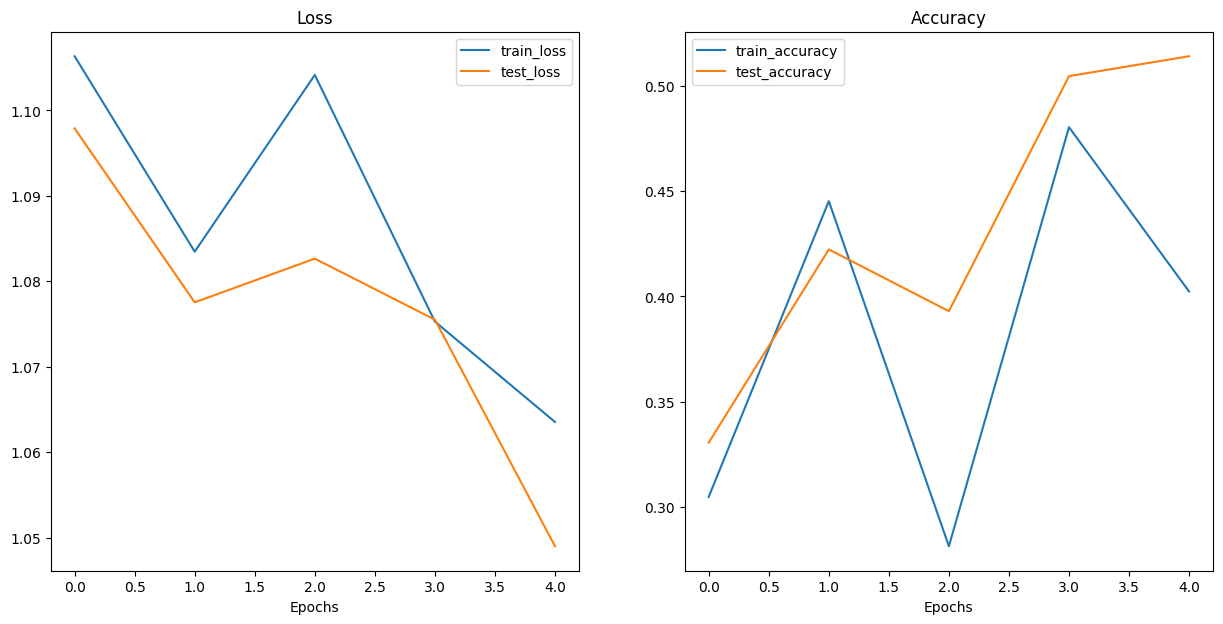

In [63]:
plot_loss_curves(model_0_results)

## 8. The ideal loss curve

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with data augmentation

Implementation of a new model using the same model as before, but with some data augmentation.

### 9.1 Create transform with data augmentation

In [64]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`s and `DataLoader`s with data augmentation

In [68]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [69]:
# Turn Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

The same model architecture will be used, except this time the training data will be augmented.

In [70]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [71]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print duration
end_time = timer()

print(f'Total training time for model_1: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train accuracy: 0.2500 | Test loss: 1.1019 | Test accuracy: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train accuracy: 0.4258 | Test loss: 1.1261 | Test accuracy: 0.2604
Epoch: 2 | Train loss: 1.0713 | Train accuracy: 0.4258 | Test loss: 1.1594 | Test accuracy: 0.2604
Epoch: 3 | Train loss: 1.1256 | Train accuracy: 0.3047 | Test loss: 1.1580 | Test accuracy: 0.2604
Epoch: 4 | Train loss: 1.0845 | Train accuracy: 0.4258 | Test loss: 1.1542 | Test accuracy: 0.3125
Total training time for model_1: 13.319 seconds


### 9.4 Plot the loss curves of model 1

A loss curve helps evaluate the model's performance overtime.

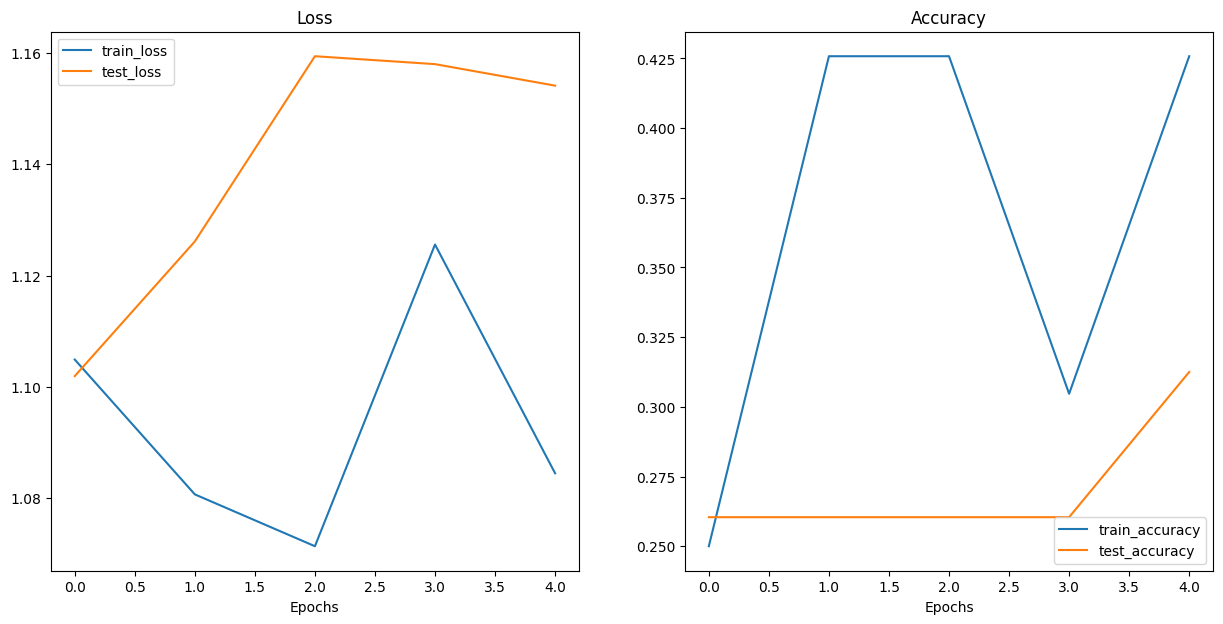

In [72]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating model experiments on their own, it is important to compare them to each other.

A few ways to do this are:
1. Hard coding (what is done here)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [73]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106343,0.304688,1.097899,0.330492
1,1.083469,0.445312,1.077538,0.422348
2,1.104150,0.281250,1.082651,0.392992
3,1.075288,0.480469,1.075510,0.504735
4,1.063536,0.402344,1.048994,0.514205


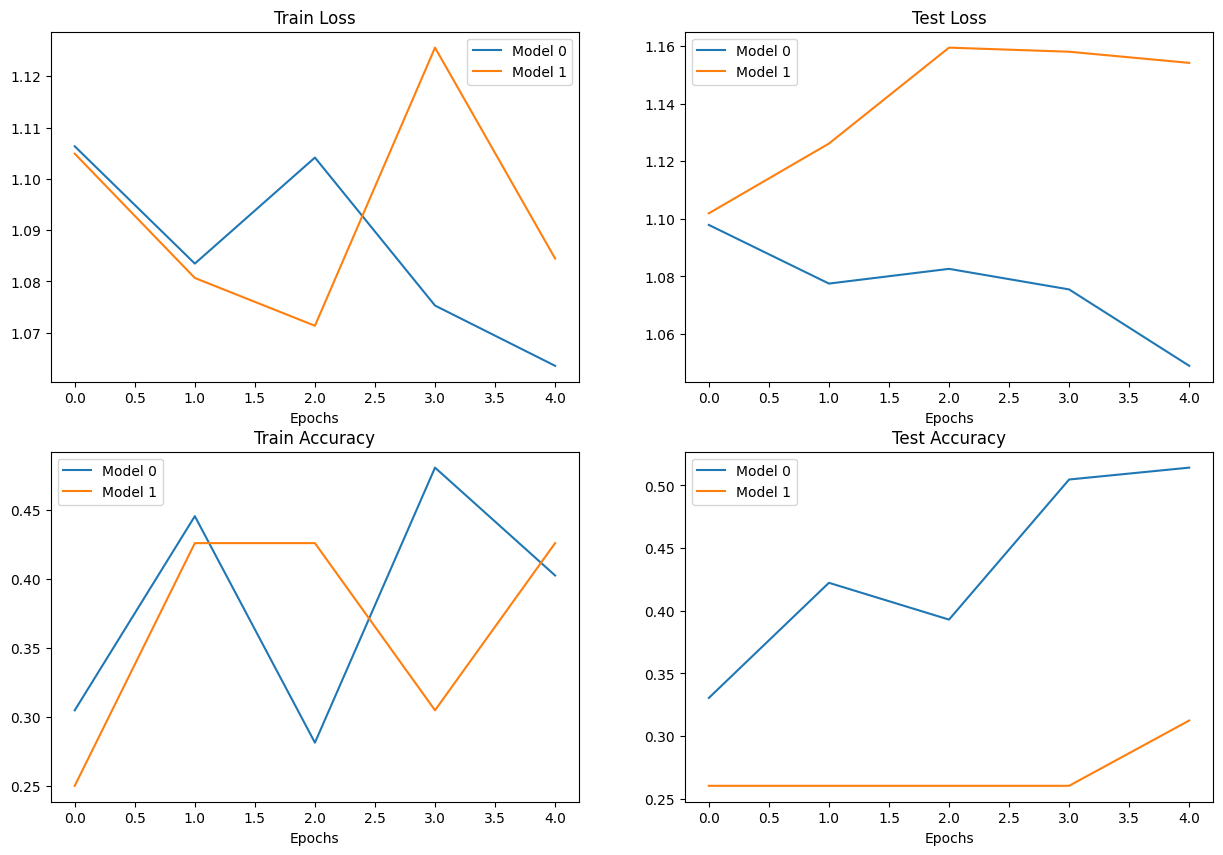

In [77]:
# Plot models' results
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot the train loss
# Train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend();
# Test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend();
# Train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend();
# Test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend();

## 11. Making a prediction on a custom image

In [78]:
# Download a custom image
import requests

# Setup image path
custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # When downloading from GitHub the raw file link is required
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path} ...')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists, skipping download...')